# Titanic - Machine Learning from the disaster

First, we need these libraries below to set up the project.

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualizzation
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

## Explore the data

Load the data from the CSV file and understand the structure

In [2]:
train = pd.read_csv("data/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv("data/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
print(f"Training set size: {train.shape}")
print(f"Test set size: {test.shape}")

Training set size: (891, 12)
Test set size: (418, 11)


### Data description

- **survival**: 0 = No, 1 = Yes
- **pclass**: Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd
- **sex**: male or female
- **age**: age in years, is fractional if less than 1
- **sibsp**: the number of siblings or spouses onboard
- **parch**: the number of parents or children onboard
- **ticket**: ticket numbers
- **fare**: passenger fare
- **cabin**: cabin number
- **embarked**: port of embarkation, where C = Cherbourg, Q = Queenstown, S = Southampton

### Statistical summary

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### Mising data

Which columns in the dataset have missing data?

<AxesSubplot:>

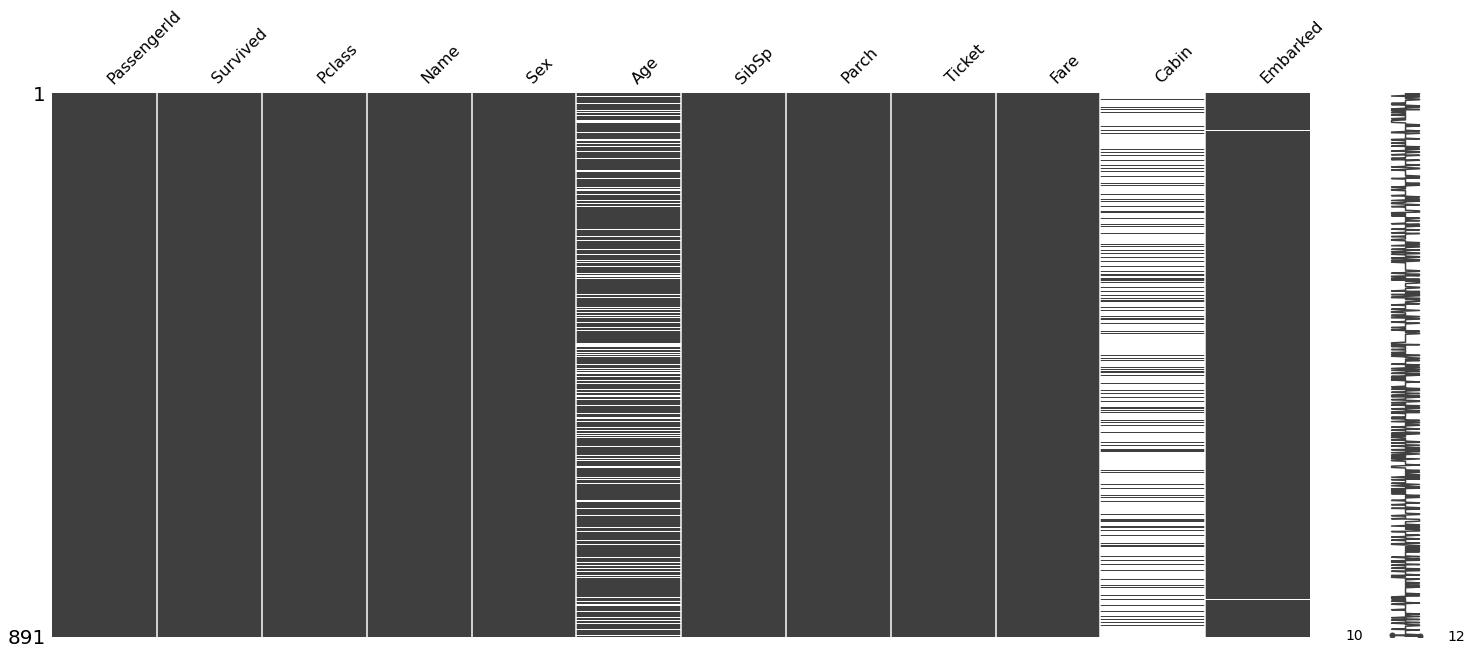

In [7]:
# Columns with missing data in training set
missingno.matrix(train)



<AxesSubplot:>

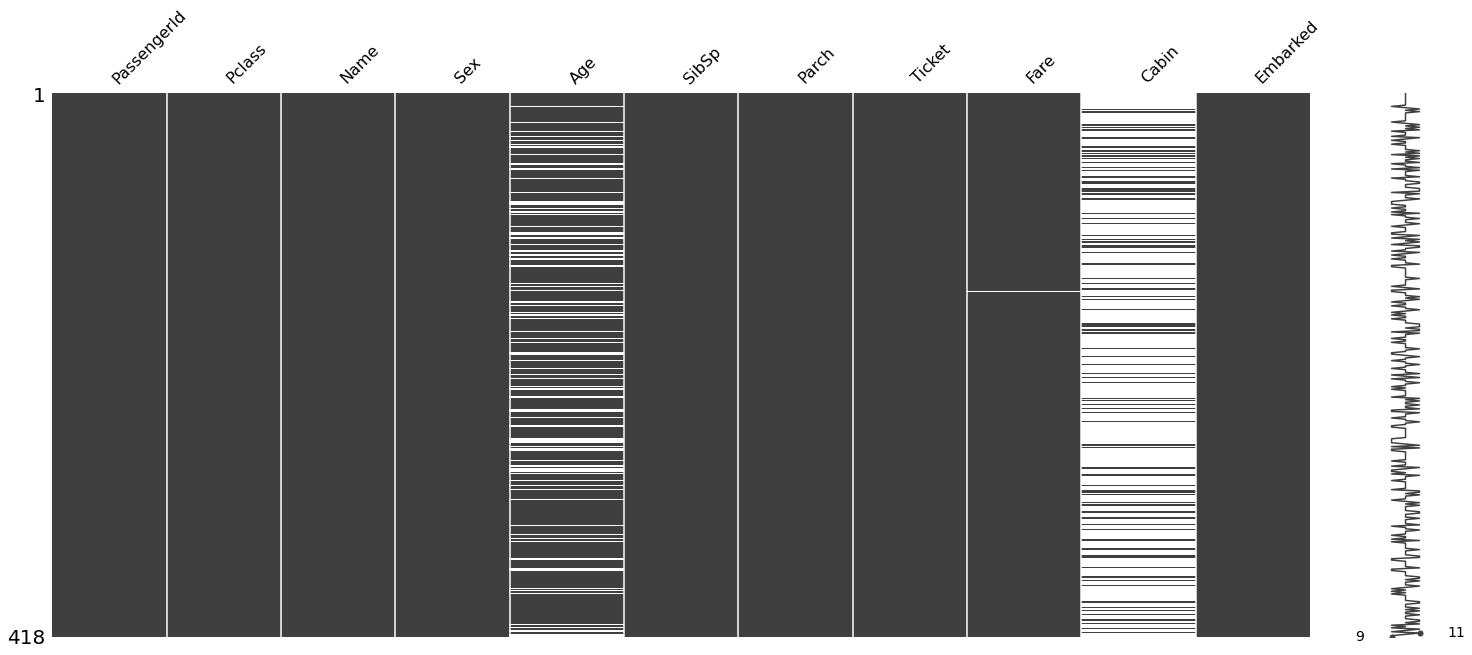

In [8]:
# Columns with missing data in test set
missingno.matrix(test)

## Data analysis

We will epxlore each variable in the data set. This may help us to choose the suitable machine learning models, or whether we need to determine the dataset.

### Categorical variables

**Sex**: the gender of the passenger, whether male or female

<AxesSubplot:xlabel='Sex', ylabel='count'>

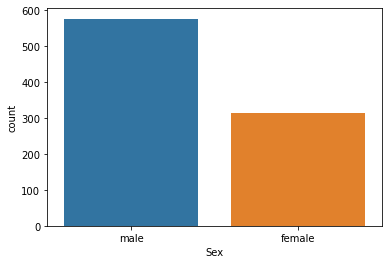

In [9]:
# Count the number of male and female passengers
sns.countplot(x="Sex", data=train)

# Comment: There are more male passenger on the ship

Text(0, 0.5, 'Survival rate')

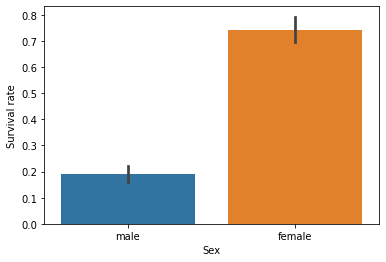

In [10]:
# Calculate the srvival rate of male and female passenger
sns.barplot(x="Sex", y="Survived", data=train)
train[['Sex', 'Survived']].groupby('Sex', as_index=False).mean()
plt.ylabel('Survival rate')

# Comment: Female passengers are more likely to survive than male passengers. Women were likely to be priotised to be evacuated.

**Pclass**: Ticket class where **1** = 1st class, **2** = 2nd class, **3** = 3rd class

<AxesSubplot:xlabel='Pclass', ylabel='count'>

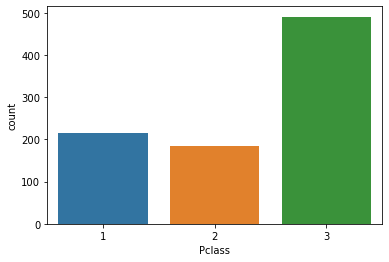

In [11]:
# Count the number of passengers based on thier ticket classes
sns.countplot(x="Pclass", data=train)

# Comment: most of the passenger had third class tickets

Text(0, 0.5, 'Survival rate')

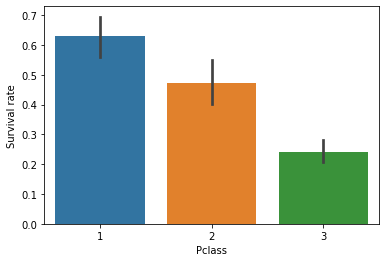

In [12]:
# What is the survival rate of passenger based on their ticket class
sns.barplot(x="Pclass", y="Survived", data=train)
plt.ylabel('Survival rate')

# Comment: The higher the ticket class, the more likely to survive. First class passengers were prioritised to be evacuated

**Embarked**: port of embarkation, where C = Cherbourg, Q = Queenstown, S = Southampton

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

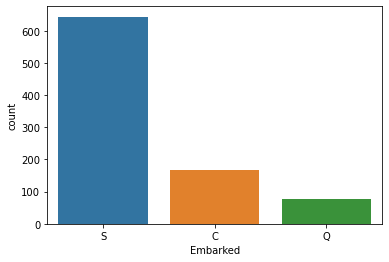

In [13]:
# Count the number of passenger based on thier port of embarkation
sns.countplot(x="Embarked", data=train)
train['Embarked'].value_counts(dropna=False)

# Comments: 
# - Two missing value from the embarkation
# - Most of the passenger are departed from Southampton ports

Text(0, 0.5, 'Survival rate')

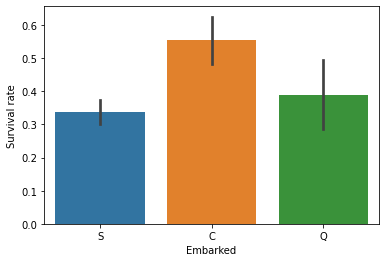

In [14]:
# What is the survival rates group by the port of embarkation?
sns.barplot(x="Embarked", y="Survived", data=train)
plt.ylabel('Survival rate')

# Comment: Passengers from Cherbougs are most likely to survive, while the least is from Southamption